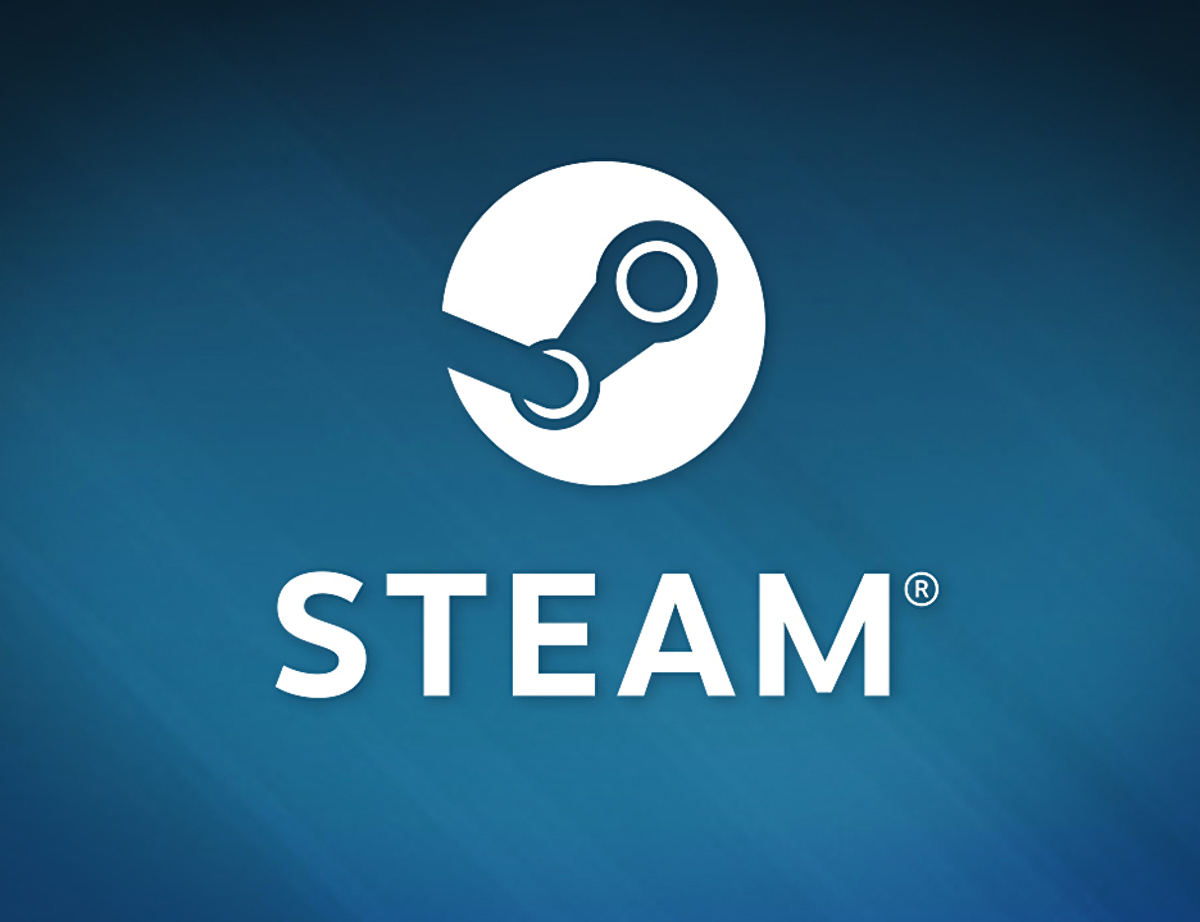

Proyecto 3
Aplicaciones actuales

Opcion seleccionada:
--> Implementa un Sistema de Recomendación para videojuegos de la plataforma Steam.

Los Datasets se obtuvieron del siguiente repositorio: https://github.com/kang205/SASRec

# Instalacion e importación de librerias

In [1]:
pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import string 
import datetime
import gzip

from sklearn import preprocessing
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split

from surprise.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Lectura de Datasets

In [3]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [4]:
url_review = '/content/drive/My Drive/Data/steam_reviews.json.gz'
contador = 0
data_reviews = []
# Vamos a guardar una de cada 15 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 15
for l in parse(url_review):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)

In [5]:
url_games = '/content/drive/My Drive/Data/steam_games.json.gz'
data_games = []
for l in parse(url_games):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

# Procesamiento de datos

## Reviews

In [6]:
data_reviews.head(4)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
2,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
3,S0YxSauCe,0.3,902.0,671270,4,2017-07-10,Easy game. All you have to do is put the hat t...,False,1,NaN,NaN,NaN


In [7]:
data_reviews.shape

(519538, 12)

In [8]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
page_order        int64
date             object
text             object
early_access       bool
page              int64
user_id          object
compensation     object
found_funny     float64
dtype: object

In [9]:
#Elimino columnas
data_reviews.drop(['page_order', 'page',
                   'early_access', 'compensation', 'found_funny',
                   'products', 'user_id'],
                   axis=1, inplace=True)

In [10]:
#Convertir a string columnas
columnas = ['username', 'text']
for i in columnas:
  data_reviews[i] = data_reviews[i].astype('string')

#Convertir a int64 columna product_id
data_reviews['product_id'] = data_reviews['product_id'].astype('int64')

#Conversion a tipo datetime64
data_reviews['Fecha'] = pd.to_datetime(data_reviews['date'])
data_reviews['Year'] = data_reviews['Fecha'].dt.year            #Nueva columna con el año del review
data_reviews['month'] = data_reviews['Fecha'].dt.month          #Nueva columna con el mes del review

In [11]:
#Elimino reviews duplicadas del mismo usuario para el mismo videojuego, dejando la mas reciente
data_reviews.drop_duplicates(subset=['username', 'product_id'], keep='first', inplace=True)

In [12]:
def valores_nulos(data):
  print('<-- Porcentaje de valores nulos -->\n')
  print(data.isnull().sum() / data.shape[0] * 100)

In [13]:
valores_nulos(data_reviews)

<-- Porcentaje de valores nulos -->

username      0.000000
hours         0.341593
product_id    0.000000
date          0.000000
text          0.000000
Fecha         0.000000
Year          0.000000
month         0.000000
dtype: float64


 ## Info Games

In [14]:
data_games.shape

(32135, 16)

In [15]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
url                object
release_date       object
tags               object
discount_price    float64
reviews_url        object
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

In [16]:
#Elimino valores nulos
data_games.dropna(subset=['tags', 'id', 'title'], axis=0, inplace=True)

In [17]:
#Convertir a string columnas
columnas = ['genres', 'title','tags']
for i in columnas:
  data_games[i] = data_games[i].astype('string')

#Convertir a int64 columna product_id
data_games['id'] = data_games['id'].astype('int64')

In [18]:
data_games.drop(['publisher','reviews_url', 'url', 
                 'early_access', 'discount_price', 
                 'app_name', 'release_date',
                 'discount_price', 'specs', 
                 'sentiment', 'metascore'],
                axis=1,
                inplace=True)

In [19]:
valores_nulos(data_games)

<-- Porcentaje de valores nulos -->

genres       3.666076
title        0.000000
tags         0.000000
price        4.103867
id           0.000000
developer    4.087157
dtype: float64


In [20]:
#Tranferencia del Nombre del videojuego segun su id
df = pd.merge(data_reviews, data_games,  left_on='product_id', right_on='id')
df.head(3)

,username,hours,product_id,date,text,Fecha,Year,month,genres,title,tags,price,id,developer
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...,2017-12-17,2017,12,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",2.99,725280,Vyacheslav Shilikhin
1,Duha Nubie,11.3,35140,2018-01-03,first debut feel sweet,2018-01-03,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"
2,MLGarbage,9.5,35140,2018-01-02,Fun Game. I played shadow of mordor before pla...,2018-01-02,2018,1,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",19.99,35140,"Rocksteady Studios,Feral Interactive (Mac)"


##Exploración de Información

In [21]:
print('Un total de {} usuarios realizaron reviews de videojuegos'.format(len(df.username.unique())))

Un total de 388027 usuarios realizaron reviews de videojuegos


In [22]:
print("<-- Top 10 Usuarios con mas reviews -->")
df.username.value_counts().head(10)

<-- Top 10 Usuarios con mas reviews -->


Alex           119
Nick            99
Jack            96
Chris           85
Dan             76
Saint Aaron     76
123             74
Kodyd194        73
Matt            71
Sam             71
Name: username, dtype: Int64

In [23]:
print('<-- Videojuegos con mas Reviews -->\n')
df.title.value_counts().head(10)

<-- Videojuegos con mas Reviews -->



Team Fortress 2                11731
Rust                            6623
Borderlands 2                   4733
Fallout 4                       4454
Grand Theft Auto V              3901
Portal 2                        3678
Undertale                       3659
DayZ                            3625
Warframe                        3553
Life is Strange - Episode 1     3345
Name: title, dtype: Int64

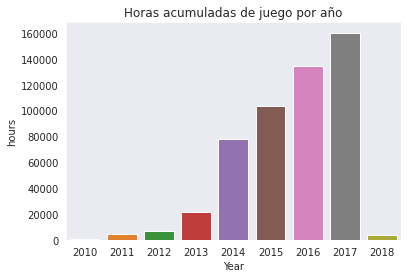

In [24]:
year_review = df.groupby(['Year']).count()
plt.title('Horas acumuladas de juego por año')
sns.barplot(x = year_review.index,
            y=year_review.hours)

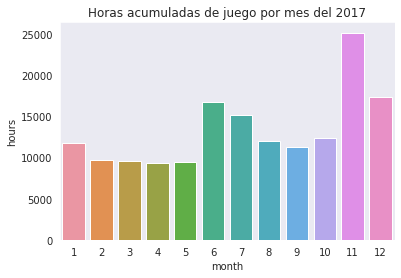

In [25]:
months_2017 = df[df['Year'] == 2017].groupby(['month']).count()
plt.title('Horas acumuladas de juego por mes del 2017')
sns.barplot(x= months_2017.index,
            y=months_2017.hours)

In [26]:
print('<-- Desarrolladores con mas videojuegos registrados -->\n')
data_games.developer.value_counts().head(10)

<-- Desarrolladores con mas videojuegos registrados -->



Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
Capcom                         130
Ronimo Games                   123
Choice of Games                100
Stainless Games                 95
Musopia                         95
Name: developer, dtype: int64

In [27]:
print('<-- Desarrolladores con mas reviews -->\n')
df.developer.value_counts().head(10)

<-- Desarrolladores con mas reviews -->



Valve                                       24337
Facepunch Studios                            9733
Bohemia Interactive                          7662
Bethesda Game Studios                        6963
Gearbox Software,Aspyr (Mac &amp; Linux)     4733
Ubisoft Montreal                             4707
Hi-Rez Studios                               4128
Daybreak Game Company                        4051
Rockstar North                               3947
Digital Extremes                             3804
Name: developer, dtype: int64

Text(0, 0.5, 'Frecuencia')

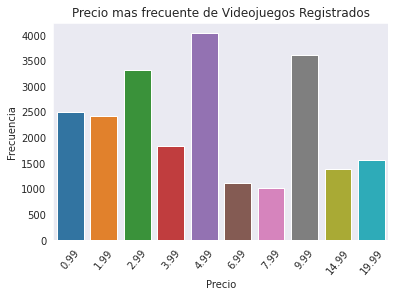

In [28]:
price_games = data_games.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente de Videojuegos Registrados')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

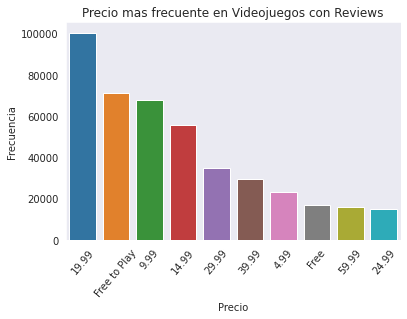

In [29]:
price_games = df.price.value_counts().head(10)
sns.barplot(x=price_games.index[0:],
            y=price_games)
plt.title('Precio mas frecuente en Videojuegos con Reviews')
plt.xticks(rotation=50)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Procesamiento de Lenguaje Natural

Realizo procesamiento de lenguaje, para intentar obtener una calificacion a la review realizada por el usuario , obteniendo una calificacion para la polaridad del comentario.
Si el comentario es positivo, el valor sera igual o cercano a 1, mientras, que, si el comentario es negativo, el valor sera igual o cercano a -1, si el comentario es neutro el valor sera cercano o igual a 0

In [30]:
df.drop(['hours', 'date', 'Fecha', 'Year', 'month', 'developer', 'price','id'], axis=1, inplace=True)

In [31]:
 #Elimino signos de puntuacion
 df['xtext'] = df['text'].str.replace('[{}]'.format(string.punctuation), ' ')

## Conversion de nombre de usuarios a numeros

In [32]:
le = preprocessing.LabelEncoder()
le.fit(df['username'])
df['x_username'] = le.transform(df['username'])

df.head(2)

,username,product_id,text,genres,title,tags,xtext,x_username
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,"['Action', 'Adventure', 'Indie', 'Simulation']",Psi Project,"['Action', 'Adventure', 'Indie', 'Simulation']",This would not be acceptable as an entertainme...,45116
1,Duha Nubie,35140,first debut feel sweet,"['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,"['Action', 'Batman', 'Stealth', 'Adventure', '...",first debut feel sweet,73962


In [33]:
#Submuestra
df_sub= df.sample(frac=0.1)
df_sub.reset_index(drop=True, inplace=True)

## Polaridad y subjetividad de reviews

In [34]:
#Creacion de una nueva columna con la polaridad de la review
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).polarity
  comentarios.append(comentario)

df_sub['polarity'] = comentarios

In [35]:
#Creacion de una nueva columna con la subjetividad de la revoew
comentarios = []

for i in range(df_sub.shape[0]):
  comentario = df_sub.xtext.iloc[i]
  comentario = TextBlob(comentario).subjectivity
  comentarios.append(comentario)

df_sub['subjectivity'] = comentarios

## Analisis de comentarios

In [36]:
#Data de videojuego con el promedio de polaridad en sus reviews
ratings = pd.DataFrame(df_sub.groupby('title')['polarity'].mean())
ratings.head()

,polarity
title,
#monstercakes,0.071667
$1 Ride,-0.500000
&gt;observer_,0.217857
- Occult preRaise -,-0.024478
.hack//G.U. Last Recode,0.296146


In [37]:
print('<-- Videojuegos con más reviews positivas-->\n')
ratings.sort_values(by='polarity', ascending=False).head(10)

<-- Videojuegos con más reviews positivas-->



,polarity
title,
Tiny Bridge: Ratventure,1.00
Orborun,1.00
Flame Over,1.00
Blind Love,1.00
Agricultural Simulator 2013 - Steam Edition,1.00
Check vs Mate,1.00
Alpha Zylon,1.00
Quell,1.00
The Initiate,0.91


In [38]:
#Nueva columna, el numero de reviews recibidas por videojuego
ratings['num_of_ratings'] = pd.DataFrame(df_sub.groupby('title')['polarity'].count())
ratings.head()

,polarity,num_of_ratings
title,,
#monstercakes,0.071667,2
$1 Ride,-0.500000,1
&gt;observer_,0.217857,2
- Occult preRaise -,-0.024478,1
.hack//G.U. Last Recode,0.296146,4


Text(0.5, 1.0, "Polaridad de Review's")

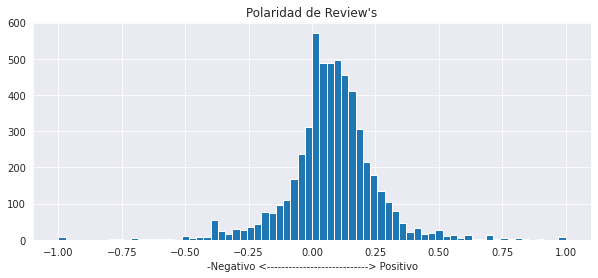

In [39]:
plt.figure(figsize=(10,4))
ratings['polarity'].hist(bins=70)
plt.xlabel('-Negativo <----------------------------> Positivo')
plt.title("Polaridad de Review's")

## Limpieza de informacion

In [40]:
#Elimino informacion de videojuegos con menos de 30 reviews
threshold = 30
value_counts = df_sub.product_id.value_counts()
to_remove = value_counts[value_counts <= threshold].index 
df_sub.replace(to_remove, np.nan, inplace=True)
df_sub.dropna(inplace=True)

# Modelo benchmark
Sistema de Recomendación basado en la la polaridad de la review.
Este Modelo Realizara recomendaciones basado en la correlación de la polaridad de la review escrita por el usuario. En donde al escribir una review positiva, el modelo le recomendará títulos con reviews muy correlacionadas a la review escrita


In [41]:
df_sub.drop(columns=['text'], inplace=True)

In [42]:
gamemat = df_sub.pivot_table(index='username',columns='title',values='polarity')
gamemat.head()

title,100% Orange Juice,A Hat in Time,A Story About My Uncle,A.V.A. Alliance of Valiant Arms™,ABZU,APB Reloaded,ARK: Survival Evolved,ASTRONEER,Absolver,Ace of Spades: Battle Builder,AdVenture Capitalist,Age of Empires II HD,Age of Empires® III: Complete Collection,Alan Wake,Alien Swarm,Alien: Isolation,Aliens vs. Predator™,American Truck Simulator,Amnesia: The Dark Descent,Antichamber,Arma 2: Operation Arrowhead,Arma 3,Assassin's Creed® Origins,Assassin's Creed® Unity,Assassin’s Creed® IV Black Flag™,Awesomenauts - the 2D moba,BLOCKADE 3D,Banished,Bastion,Batman: Arkham Asylum Game of the Year Edition,Batman™: Arkham Knight,Batman™: Arkham Origins,BattleBlock Theater®,Battleborn,Battlefield: Bad Company™ 2,Battlerite,BeamNG.drive,BioShock® 2,BioShock™,BioShock™ Remastered,...,The Stanley Parable,The Talos Principle,The Walking Dead,The Walking Dead: Season 2,The Witcher 2: Assassins of Kings Enhanced Edition,Thief,This War of Mine,Thomas Was Alone,To the Moon,Tom Clancy's Rainbow Six® Siege,Tom Clancy’s The Division™,Torchlight II,Total War™: ROME II - Emperor Edition,Town of Salem,Train Simulator,Transformice,Transistor,Tree of Savior (English Ver.),Tribes: Ascend,Trine 2: Complete Story,Tropico 4,Trove,Undertale,Unturned,Verdun,WARMODE,Wallpaper Engine,Warface,Warframe,Wargame: Red Dragon,"Warhammer 40,000: Dawn of War II",Warhammer: End Times - Vermintide,Watch_Dogs® 2,Who's Your Daddy,Wolfenstein II: The New Colossus,Wolfenstein: The New Order,World of Guns: Gun Disassembly,XCOM: Enemy Unknown,XCOM® 2,theHunter Classic
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
! *,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!Depressed Führer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!False696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.135714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!JuiCy!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
!MAD! IGOR KAZIMIR cs.money,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#Elimino videojuegos con menos de 30 reviews
gamemat = gamemat.dropna(thresh=30, axis=1).fillna(0,axis=1)

In [44]:
corrMatrix = gamemat.corr(method='pearson')
corrMatrix.head(5)

title,100% Orange Juice,A Hat in Time,A Story About My Uncle,A.V.A. Alliance of Valiant Arms™,ABZU,APB Reloaded,ARK: Survival Evolved,ASTRONEER,Absolver,Ace of Spades: Battle Builder,AdVenture Capitalist,Age of Empires II HD,Age of Empires® III: Complete Collection,Alan Wake,Alien Swarm,Alien: Isolation,Aliens vs. Predator™,American Truck Simulator,Amnesia: The Dark Descent,Antichamber,Arma 2: Operation Arrowhead,Arma 3,Assassin's Creed® Origins,Assassin's Creed® Unity,Assassin’s Creed® IV Black Flag™,Awesomenauts - the 2D moba,BLOCKADE 3D,Banished,Bastion,Batman: Arkham Asylum Game of the Year Edition,Batman™: Arkham Knight,Batman™: Arkham Origins,BattleBlock Theater®,Battleborn,Battlefield: Bad Company™ 2,Battlerite,BeamNG.drive,BioShock® 2,BioShock™,BioShock™ Remastered,...,The Stanley Parable,The Talos Principle,The Walking Dead,The Walking Dead: Season 2,The Witcher 2: Assassins of Kings Enhanced Edition,Thief,This War of Mine,Thomas Was Alone,To the Moon,Tom Clancy's Rainbow Six® Siege,Tom Clancy’s The Division™,Torchlight II,Total War™: ROME II - Emperor Edition,Town of Salem,Train Simulator,Transformice,Transistor,Tree of Savior (English Ver.),Tribes: Ascend,Trine 2: Complete Story,Tropico 4,Trove,Undertale,Unturned,Verdun,WARMODE,Wallpaper Engine,Warface,Warframe,Wargame: Red Dragon,"Warhammer 40,000: Dawn of War II",Warhammer: End Times - Vermintide,Watch_Dogs® 2,Who's Your Daddy,Wolfenstein II: The New Colossus,Wolfenstein: The New Order,World of Guns: Gun Disassembly,XCOM: Enemy Unknown,XCOM® 2,theHunter Classic
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100% Orange Juice,1.000000,-0.000057,-0.000048,-0.000007,-0.000047,-0.000008,-0.000028,-0.000034,-0.000012,-0.000015,-0.000038,-0.000083,-0.000049,-0.000047,-0.000061,-0.000032,-0.000022,-0.000058,-0.000014,-0.000031,-0.000050,-0.000101,-0.000029,-0.000005,-0.000052,-0.000058,-6.175915e-07,-0.000056,-0.000106,-0.000054,-0.000065,-0.000015,-0.000041,-0.000037,-0.000050,-0.000064,-0.000013,-0.000048,-0.000060,-0.000017,...,-0.000052,-0.000040,-0.000041,-0.000056,-0.000069,0.000009,-0.000006,-0.000060,-0.000064,-0.000072,-0.000038,-0.000085,-0.000041,-0.000056,-0.000030,-0.000002,-0.000093,-0.000025,-0.000032,-0.000063,-0.000023,-0.000066,-0.000104,-0.000025,-0.000070,-0.000010,-0.000084,-0.000042,-0.000111,-0.000038,-0.000032,-0.000011,-0.000036,-0.000010,-0.000020,-0.000082,0.000002,-0.000060,-0.000051,-0.000009
A Hat in Time,-0.000057,1.000000,-0.000521,-0.000076,-0.000506,-0.000083,-0.000296,-0.000363,-0.000124,-0.000161,-0.000412,-0.000897,-0.000524,-0.000507,-0.000653,-0.000340,-0.000231,-0.000627,-0.000152,-0.000337,-0.000535,-0.001085,-0.000317,-0.000052,-0.000556,-0.000622,-6.641717e-06,-0.000600,-0.001135,-0.000576,-0.000696,-0.000163,-0.000441,-0.000400,-0.000538,-0.000690,-0.000138,-0.000515,-0.000642,-0.000185,...,-0.000554,-0.000434,-0.000444,-0.000604,-0.000746,0.000092,-0.000068,-0.000645,-0.000687,-0.000773,-0.000411,-0.000919,-0.000438,-0.000600,-0.000318,-0.000026,-0.001002,-0.000264,-0.000344,-0.000680,-0.000251,-0.000708,-0.001114,-0.000264,-0.000749,-0.000105,-0.000899,-0.000449,-0.001192,-0.000404,-0.000347,-0.000117,-0.000389,-0.000112,-0.000217,-0.000886,0.000020,-0.000644,0.008752,-0.000098
A Story About My Uncle,-0.000048,-0.000521,1.000000,-0.000065,-0.000429,-0.000071,-0.000251,-0.000307,-0.000105,-0.000136,-0.000349,-0.000760,-0.000444,-0.000430,-0.000553,-0.000288,-0.000196,-0.000531,-0.000129,-0.000285,-0.000453,-0.000919,-0.000268,-0.000044,-0.000471,-0.000527,-5.628511e-06,-0.000508,-0.000962,-0.000488,-0.000589,-0.000138,-0.000373,-0.000339,-0.000456,-0.000584,-0.000117,-0.000437,-0.000544,-0.000157,...,-0.000470,-0.000367,-0.000376,-0.000512,-0.000632,0.000078,-0.000057,-0.000546,-0.000582,-0.000655,-0.000348,-0.000779,-0.000371,-0.000509,-0.000269,-0.000022,-0.021537,-0.000223,-0.000291,-0.000576,-0.000213,-0.000600,-0.000944,-0.000224,-0.000635,-0.000089,-0.000762,-0.000380,-0.001010,-0.

In [45]:
def get_similar(game_name,rating):
    similar_ratings = corrMatrix[game_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [46]:
def get_random_game():
  all_games = data_games[['id', 'title']]
  #Selecciona un usuario al azar
  x = int(np.random.randint(df_sub.shape[0], size=1))
  x = df_sub.username.iloc[x]
  usuario = df[df['username'] == x]
  print('--> El usuario ha jugado: ',usuario.shape[0], 'videojuegos')
  #Elimino titulos que el usuario ya ha jugado
  for i in usuario.title:
    game = i
    all_games.drop(all_games[all_games['title'] == game ].index, inplace=True)
    
  #Obtengo un titulo al azar
  game = df_sub.title.iloc[int(np.random.randint(df_sub.shape[0], size=1))]
  print(' * Videjuego seleccionado:', game)

  #Solicito al usuario escriba su review(Tiene que ser en ingles) para analizar su polaridad
  rating = str(input('--> Ingrese la review del videojuego: '))
  rating = TextBlob(rating).polarity

  #Obtengo titulos con polaridades similares
  similar_games = pd.DataFrame()
  similar_games = similar_games.append(get_similar(game,rating),ignore_index = True)
  x = similar_games.sum().sort_values(ascending=False).head(10)

  #Elimino los juegos que el usuario ya ha jugado
  for i in x.index:
    name = i
    usuario.drop(usuario[usuario['title'] == name ].index, inplace=True)

  print('<------------------------->')
  print("Nuestra recomendaciones para usted: \n")
  for i in x.index:
    print(i)

In [47]:
get_random_game()

--> El usuario ha jugado:  1 videojuegos
 * Videjuego seleccionado: Killing Floor 2
--> Ingrese la review del videojuego: the best game ever
<------------------------->
Nuestra recomendaciones para usted: 

Metro 2033 Redux
Team Fortress 2
Arma 3
Portal 2
Life is Strange - Episode 1
Warframe
Bastion
Undertale
Robocraft
Transistor


EL modelo Benchmark arrojó el título de videojuegos que presentan una alta correlación con la puntuación obtenida por medio de TexBlob en cuanto a la polaridad de la review escrita por el usuario.
Este modelo al depender de la correlación de la review escrita por el usuario, si el usuario realiza una review negativa, el modelo le recomendará títulos que presenten reviews negativas.


# Machine Learning

## Surprise

In [48]:
#Creo una copia de las review, que mas adelante empleare
calificaciones = df_sub[['x_username', 'product_id', 'polarity']]

El Dataset `calificaciones` contiene la informacion del numero de usuario, el id del videojuego asi como la polaridad de la review que el usuario realizo. Este DataSet se empleara como Data para el modelo Surprise

In [49]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(calificaciones, test_size = 0.2, random_state=40)

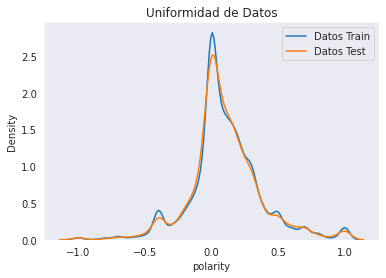

In [50]:
sns.kdeplot(train_data['polarity'], label='Datos Train')
sns.kdeplot(test_data['polarity'], label='Datos Test')
plt.title('Uniformidad de Datos')
plt.legend()

Con base en el gráfico, la división de la data empleando train_test_split , esta no presenta desbalance, en donde en los datos de entrenamiento se presente más reviews negativas mientras que en los datos de test reviews positivas. Por lo que mi división de datos es la adecuada, encontrando en los datos de entrenamiento y test calificaciones muy similares en ambos casos

In [51]:
reader = Reader(rating_scale = (-1.00, 1.00))
data_train = Dataset.load_from_df(train_data[['x_username', 'product_id', 'polarity']], reader)
data_test = Dataset.load_from_df(test_data[['x_username', 'product_id', 'polarity']], reader)

In [52]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [53]:
print('Calificaciones globales :')
print('Train rating', data_train.global_mean)
print('Test rating', data_test.global_mean)

Calificaciones globales :
Train rating 0.10390252402059845
Test rating 0.10139977000068108


In [54]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [55]:
# Create SVD 
from surprise import SVD
algo = SVD()
#Entreno el modelo
algo.fit(data_train)

In [56]:
# RMSE en datos de entrenamiento
from surprise import accuracy
train_pred = algo.test(data_trainset)
rmse_train = accuracy.rmse(train_pred)
print(rmse_train)

RMSE: 0.2162
0.21615864018268585


In [57]:
#RMSE en datos de test
test_pred = algo.test(data_testset)
rmse_test = accuracy.rmse(test_pred)
print(rmse_test)

RMSE: 0.2675
0.2675025416072473


In [58]:
train_data.head(2)

,x_username,product_id,polarity
23086,120259.0,273350.0,0.076667
34207,123958.0,278360.0,0.700000


In [59]:
# Prediccion con datos de entrenamiento
p1 = algo.predict(uid = train_data.iloc[0].x_username, iid = train_data.iloc[0].product_id, verbose = True)

user: 120259.0   item: 273350.0   r_ui = None   est = 0.12   {'was_impossible': False}


El modelo realizo la prediccion, en donde el usuario 120259.0 para el videojuego con el id: 273350.0, obtendria una puntuacion de 0.12. Cuando el usuario le asigno el valor de 0.07

In [60]:
test_data.x_username.value_counts().head(5)

119162.0    3
201356.0    3
377817.0    3
13525.0     2
219762.0    2
Name: x_username, dtype: int64

In [61]:
#Selecciono al usuario con aparicion
usuario = test_data[test_data['x_username'] == 119162.0]
usuario

,x_username,product_id,polarity
32833,119162.0,252490.0,0.100000
38493,119162.0,33930.0,0.183333
14806,119162.0,444090.0,0.350000


Empleo el usuario con mayor reviews en mis datos de Test, para realizar predicciones

In [62]:
usuario['estimate_escore'] = usuario['product_id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)
usuario

,x_username,product_id,polarity,estimate_escore
32833,119162.0,252490.0,0.100000,0.078230
38493,119162.0,33930.0,0.183333,0.057101
14806,119162.0,444090.0,0.350000,-0.056608


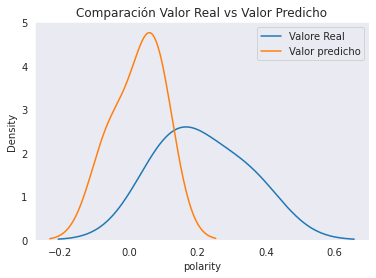

In [63]:
sns.kdeplot(usuario['polarity'], label='Valore Real')
sns.kdeplot(usuario['estimate_escore'], label='Valor predicho')
plt.title('Comparación Valor Real vs Valor Predicho')
plt.legend()

El modelo con sus hyperparametros por default, realiza predicciones distantes a la puntuación real. Se tomara esto como base a modo de comparativa al optimizar sus hyperparametros.

## Optimizacion de Hyperparametros

In [64]:
reader = Reader(rating_scale = (-1.00, 1.00))
data = Dataset.load_from_df(calificaciones[['x_username', 'product_id', 'polarity']], reader)

Selección de hyperparametros:
- n_epochs: Establezco como maximo un numero de iteraciones de 200
- lr_all: Este parametro se refiere a la taza de aprendizaje, por lo que empleo valores menores al que se presenta por default
- reg_all:  Regularización de paramaetros, se establecen tres valores muy cercanos e igual a 0
- biased: Se empleara el valor por Default
- init_mean: Se empleara el valor por Default
- init_std_dev: Se empleara el valor por Default

In [65]:
param_grid = {
    'n_factors': [5,10,15],
    'n_epochs' : [100,150,200],
    'lr_all'   : [0.002, 0.005, 0.02],
    'reg_all'  : [0, 0.002, 0.02],
    'biased'   : [True],
    'init_mean': [0],
    'init_std_dev': [0.01]
    }
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1)
gs.fit(data)

In [66]:
print("Mejores parametros : "+str(gs.best_params))
print("Mejor Score : "+str(gs.best_score)+'\n')

Mejores parametros : {'rmse': {'n_factors': 10, 'n_epochs': 100, 'lr_all': 0.002, 'reg_all': 0.02, 'biased': True, 'init_mean': 0, 'init_std_dev': 0.01}}
Mejor Score : {'rmse': 0.2696101132329949}



In [67]:
#Establecer modelo con los hyperparametros 
svd_tunned = SVD(n_factors = 10, n_epochs= 100, biased= True, lr_all= 0.002, reg_all= 0.02, init_mean= 0, init_std_dev= 0.01)
#Entrenar modelo
svd_tunned.fit(data_train)

In [68]:
#RMSE en datos de train
train_pred = algo.test(data_trainset)
rmse_train_tuned = accuracy.rmse(train_pred)
print(rmse_train_tuned)

RMSE: 0.2162
0.21615864018268585


In [69]:
#RMSE en datos de train
test_pred = algo.test(data_testset) 
rmse_test_tuned = accuracy.rmse(test_pred)
print(rmse_test_tuned)

RMSE: 0.2675
0.2675025416072473


In [70]:
#Comparativa
print('SVD parametros por default')
print('RMSE en datos de Entrenamiento:' ,rmse_train)
print('RMSE en datos de Test: ', rmse_test)
print('<---------------------------------->')
print('SVD con optimizacion de hyperparametros')
print('RMSE en datos de Entrenamiento: ',rmse_train_tuned)
print('RMSE en datos de Test: ', rmse_test_tuned)

SVD parametros por default
RMSE en datos de Entrenamiento: 0.21615864018268585
RMSE en datos de Test:  0.2675025416072473
<---------------------------------->
SVD con optimizacion de hyperparametros
RMSE en datos de Entrenamiento:  0.21615864018268585
RMSE en datos de Test:  0.2675025416072473


In [71]:
#Nuevas predicciones
usuario['new_estimate_escore'] = usuario['product_id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)
usuario

,x_username,product_id,polarity,estimate_escore,new_estimate_escore
32833,119162.0,252490.0,0.100000,0.078230,0.078230
38493,119162.0,33930.0,0.183333,0.057101,0.057101
14806,119162.0,444090.0,0.350000,-0.056608,-0.056608


Con base en el grafico, el modelo optimizado, realiza predicciones con valores muy distantes a la realidad. Para un mejor rendimiento se debe de hacer un mejor procesamiento de la información. Ya que que en la Data se presentan muchos usuarios con una recomendación, por lo que el modelo tendra que predecir el resto de los resultados teniendo muy poca información base.

In [72]:
def games_top_predict():
  all_games = data_games[['id', 'title']]
  #Seleccion de usuario al azar
  x = int(np.random.randint(df_sub.shape[0], size=1))
  x = df_sub.username.iloc[x]
  usuario = df[df['username'] == x]
  print('Usuario seleccionado: {}'.format(usuario.iloc[0].username))
  print('--> El usuario ha jugado: ',usuario.shape[0], 'videojuegos')

  #Elimino videojuegos jugados
  for i in usuario.title:
    game = i
    all_games.drop(all_games[all_games['title'] == game ].index, inplace=True)
  
  #Seleccion de videojuego al azar
  game = df_sub.title.iloc[int(np.random.randint(df_sub.shape[0], size=1))]
  print(' * Videjuego seleccionado:', game)
  input('--> Ingrese la review del videojuego: ')

  #Prediccion
  all_games['estimate_escore'] = all_games['id'].apply(lambda x: algo.predict(uid = usuario.x_username.iloc[0],iid = x).est)

  top = all_games.sort_values(ascending=False, by='estimate_escore').head(5)
  print('\n Nuestra recomendacion de Videojuegos :\n')
  for i in top['title']:
    print('---> ', i)

In [73]:
games_top_predict()

Usuario seleccionado: PadrePio
--> El usuario ha jugado:  1 videojuegos
 * Videjuego seleccionado: Garry's Mod
--> Ingrese la review del videojuego: the best game

 Nuestra recomendacion de Videojuegos :

--->  Scribblenauts Unlimited
--->  Divinity: Original Sin 2
--->  Battlefield: Bad Company™ 2
--->  Star Wars: Battlefront 2 (Classic, 2005)
--->  Wallpaper Engine


# Recomendaciones Basadas en Generos


Este sistema de recomendación se basa en la similitud del genero del videojuego del cual se realiza la review

In [74]:
#Submuestra
df_games = data_games.sample(frac=0.04)
df_games.reset_index(drop=True, inplace=True)

df_reviews = data_reviews.sample(frac=0.04)
df_reviews.reset_index(drop=True, inplace=True)

In [75]:
 #df_games['tags'] = df_games['tags'].fillna(' ')
 df_games['xtags'] = df_games['tags'].str.replace('[{}]'.format(string.punctuation), ' ')

In [76]:
stopwords = nltk.corpus.stopwords.words('english')        #Defino las stopwords
tfidf = TfidfVectorizer(stop_words=set(stopwords))        #Defino el modelo
tfidf_matrix = tfidf.fit_transform(df_games['xtags'])   #Creo matriz

In [77]:
'''
Matriz de comparación
Compara las etiquetas de un video seleccionado con la lista anterior
en busca de palabras similares
'''
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [78]:
print(len(tfidf.vocabulary_))
print(tfidf_matrix.shape)

331
(1197, 331)


In [79]:
indices = pd.Series(df_games.index, index=df_games['title']).drop_duplicates()

In [80]:
def get_recomendation(title, cosine_sim=cosine_sim):
    idx = indices[title]                                                        #Selecciona el titulo del videojuego                        
    sim_scores = list(enumerate(cosine_sim[idx]))                               
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)           #Ordena de mayor a menor las similitudes
    sim_scores = sim_scores[1:6]                                                #Selecciona las primero 5 similitudes
    games_indices = [i[0] for i in sim_scores]
    return df_games['title'].iloc[games_indices]                                #Retorna el nombre de los videojuegos

In [81]:
def recomendation():
  '''
  Se seleccionara un id de un videojuego al azar, simulando que el usuario ya selecciono
  el videojuego que va jugar y escribir su reseña'''
  ids  = np.random.randint(df_games.shape[0])                         #Obtiene una linea al azar
  ids  = df_games.id.iloc[ids]                                        #Obtiene el id del videojuego seleccionado al azar
  name = (df_games.loc[df_games['id'] == ids]['title']).iloc[0]       #Busca el nombre del id del videojuego 
  print('Usted ha jugado: {}'.format(name))
  input('Ingrese su reseña: ')
  print('\nNuestras recomendaciones basadas en su ultima review:')
  print(get_recomendation(name))

In [82]:
recomendation()

Usted ha jugado: Rocksmith® 2014 – The Toadies - “Possum Kingdom”
Ingrese su reseña: Buen juego

Nuestras recomendaciones basadas en su ultima review:
37     Rocksmith® 2014 – Thirty Seconds to Mars - “Th...
60     Rocksmith® 2014 – The Libertines - “What Katie...
67        Rocksmith® 2014 – Rocksmith Goes to the Movies
92     Rocksmith® 2014 Edition – Remastered – Royal B...
155    Rocksmith® 2014 – Mastodon - “Colony Of Birchmen”
Name: title, dtype: string


# Conclusión

Modelo Machine Learning: El modelo SVD, se realizó su optimización de sus hyperparmetros, sin embargo este no presenta gran cambio en el RMSE. Posiblemente causado por que no se realizó una búsqueda exhaustiva de los mejores parámetros. Además de contar con una escasa información sobre usuarios. Ya que existen usuarios que solo han realizado una o dos reviews, mientras existen una gran cantidad de videojuegos. Por lo que entre mas review realice el usuario más recomendaciones acertadas realizara el modelo SVD


De los tres modelos presentados, basados en el zen de python en donde `Simple is better than complex`. Mi modelo de elección es el modelo de recomendación basado en la similitud del género del título jugado. Ya que realiza recomendaciones acertadas. Teniendo la problemática, si el usuario no le gusto el titulo jugado, este modelo le mostrará títulos similares

# Investigacion

###Posibles mejoras:


Dado que yo empleo la Libreria TextBlob para analizar la positividad de la review escrita, en busca de encontrar una calificación al videojuego. Obteniendo una polaridad del comentario negativo obtendrá  un valor cercano o igual a -1 , mientras una review positiva obtiene un valor cercano o igual a 1. Sin embargo, la review tendrá que ser muy positiva para que obtenga el valor de 1. Es decir el usuario necesita realizar una review que presente diversas palabras positivas para que TextBlob le asigne un valor igual a 1. Por lo que si un usuario no es muy expresivo y es muy concreto en su review, aunque, esta sea positiva, TextBlob no le asignará una calificación muy positiva. Ejemplo:


In [83]:
review = 'good game'
TextBlob(review).polarity

0.14999999999999997

El usuario al no emplear muchas palabras positivas , esta no obtiene una calificación alta. Por lo que TextBlob depende mucho de la cantidad de palabras presentes para asignar una calificación.


Sin embargo `NaiveBayesClassifier` únicamente realiza una clasificación, si el comentario es positivo o negativo. Por lo que una vez se obtiene esta clasificación , se podría emplear LabelEncore para obtener una valor numérico, por ejemplo siendo 1 una review positiva y 0 una review negativa. La desventaja o no, es que `NaiveBayesClassifier` requiere una base de texto para su entrenamiento, en donde se especifiquen cuales frases son positivas o negativas. Por lo que , para la creación de esta base de datos se requiere de un previo estudio y clasificación de las review , con el fin de encontrar las frases mas repetitivas en el caso de que sean positivas o negativas, y pasarlas a la base de entrenamiento

### Para probar

Me gustaria aplicar un sistema de aplicando los tres modelos presentados en el presente proyecto.
Es decir:
- Aplicar un modelo en donde el usuario ingrese la review del videojuego, analizando la positividad de la review, en donde al ser positiva se muestran 2 videojuegos con el promedio de review más alta, posteriormente se emplea el modelo SVD para realizar la predicción de calificación sobre el total de videojuegos y se obtendrán los 2 videojuegos más altos y por último se mostrarán 2 videojuegos que tengan el mismo género que el título jugado. Por lo que el usuario obtendrá una recomendación final de 6 títulos recomendados, basados en diferentes sistemas de recomendación.


Otra idea para aplicar, sería emplear el modelo LogisticRegression, una vez que tengo la clasificación de la review en negativa o positiva como binario.Sin Embargo, existe la problemática en donde existe usuarios en donde solo han escrito una review y el modelo tendría demasiados errores, por lo que se emplea la información de los usuarios con mayor número de reviews como medida de disminuir los errores.




### Resultados esperados

Al implementar un nuevo modelo en donde combine los tres modelo presentados. El usuario obtendrá mejores recomendaciones, basadas en tres diferentes parámetros. Evitando la problemática en donde los juegos con mas reviews positivas o los mas jugados siempre sean recomendados y están siempre entre los más recomendados, mientras que los juegos nuevos y de baja exposición tendrá una gran dificultad para ser recomendados. Esto se evita con el modelo de similitud de género del título jugado, ya que si el usuario nuevo juega un título del género similar a un juego nuevo, este juego recientemente lanzado, tendrá más probabilidad de ser recomendado y comenzar a ganar nuevos usuarios.